In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline,interp1d 
from os import listdir,path,walk
import matplotlib as mpl
from scipy.signal import savgol_filter
import lmfit as lm
import scipy.stats as stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import date

mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format

# Two-Channel  tracking

## Functions

In [3]:
def load_single_file(path,drop=True):
    f = pd.read_csv(path)
    if drop:
        if type(f["TRACK_ID"].iloc[0])==str:
            if drop:
                f=f[3:]     
                f=f.drop("LABEL",1)
        f=f.apply(pd.to_numeric, errors='coerce')   

    return(f)

In [4]:

def generalized_gaussian(x,a,b,c,off,to):
    return(c*np.exp(-a*((x-to)**2)**b)+off)

class make_average():    
        
    def __init__(self,data,plot_params,do_mosaic):              
        self.data       = data
        self.ntracks    = len(data)        
        self.plot_params= plot_params
        self.do_mosaic  = do_mosaic
    
        
    def loading_inten_file(self,idc):        
        data_track = self.data_track.copy()
        idp = data_track["Protein"].values[0]
        idf,ids,to,tf,xo,yo = data_track[["FILE_ID","SET_ID",
                                            "TRACK_START","TRACK_STOP",
                                            "TRACK_X_LOCATION","TRACK_Y_LOCATION"]].astype(int).values[0]  
        
        homec = home + "Results/Intensity_Profiles/%s"%idp
        if idc==1:
            input_folder = homec+"/Replicate_%s"%ids
            inten  = pd.read_csv(input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))
            self.lent = len(inten)            

        if idc==2:
            input_folder = homec+ "/Sel_Tracks"

            try:
                inten  = pd.read_csv(input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))
            except:
                print("Warning: File  ", input_folder+"/Results_x_%d_Y_y_%d_from_%d_to_%d_set_%s_file_%d_C%d.csv"%
                        (xo,yo,to,tf,ids,idf,idc))

            if ids > 0 and idp != "Sec17":
                inten["Frame"] += max(to-27,0)
                inten.index    += max(to-27,0)

                for k in range(0,min(inten.index)):
                    inten.at[k,:] = 0
                    inten.at[k,"Frame"] = k
                for k in range(max(inten.index),self.lent):
                    inten.at[k,:] = 0
                    inten.at[k,"Frame"] = k  
                inten.sort_index(inplace=True)        
        self.inten = inten

    def run_average(self):
    
        do_mosaic = self.do_mosaic
        data      = self.data.copy()
        params    = self.plot_params        

        ids_WalkAv = params["Raw"]
        BG         = params["BG"]            
        norm       = params["Norm"]
        id_x       = params["IdX"]
        do_aligned = params["do_aligned"]            
        do_savfil  = params["do_savfil"]
        show_C2    = params["show_C2"]
        show_fit   = params["show_fit"]

        f_in ={}
        f_fil={}
        f_bg ={}
        ts  = np.arange(-60,60,0.2)

        inten_exo84  = np.zeros_like(ts)
        inten2_exo84 = np.zeros_like(ts)

        ntracks  = 0 
        intenC2  = {}        
        intenC1  = {}

        for idprot,idp in enumerate(data["Protein"].unique()):

            data_sel = data.query("Protein == '%s'"%idp).copy()

            if do_mosaic:            
                cols = int(np.sqrt(len(data_sel))) 
                rows = len(data_sel)//cols + 1
                fig,axes  = plt.subplots(rows,cols,figsize=(5*cols,5*rows))
                axes = np.ravel(axes)

            idfig = 0                

            inten_C2     = np.zeros_like(ts)    
            inten2_C2    = np.zeros_like(ts)
            inten_C1     = np.zeros_like(ts)    
            inten2_C1    = np.zeros_like(ts)
            np_tracks    = 0    

            for l,id in enumerate(data_sel.index):            

                data_track = data_sel.loc[id:id].copy()
                self.data_track = data_track
                fr,idp,idf,ids,to_C1,tf_C1,to_C2,tf_C2 = data_track[["FR","Protein",
                                                "FILE_ID","SET_ID",
                                                "TRACK_START","TRACK_STOP",
                                                "To_CH2","Tf_CH2"]].values[0]                        
                dur_C1= (tf_C1-to_C1)*fr            
                to_C2 = int(data_sel.loc[id,"To_CH2"]/fr+ to_C1)
                tf_C2 = int(data_sel.loc[id,"Tf_CH2"]/fr + to_C1)               

                shift_C1= (tf_C1+to_C1)/2  # All timepoints are defined respect to track_center_C1 by default           
                to_C1   = (to_C1-shift_C1)*fr 
                tf_C1   = (tf_C1-shift_C1)*fr 
                to_C2   = (to_C2-shift_C1)*fr
                tf_C2   = (to_C2-shift_C1)*fr
                shift_C2= (to_C2+tf_C2)/2 *fr

                for idc in [1,2]:

                    Imax  = data_track["Imax_C%d"%idc].values[0]
                    self.loading_inten_file(idc)
                    inten = self.inten.copy()
                    
                    f_in["C%d"%idc]  = inten["Mean_X%s"%id_x]  if ids_WalkAv  else inten["Mean_DoG_X%s"%id_x]                
                    f_fil["C%d"%idc] = savgol_filter(f_in["C%d"%idc],3,1) 
                    f_bg["C%d"%idc]  = inten["Mean_BG_X%s"%id_x]  if ids_WalkAv else inten["Mean_DoG_BG_X%s"%id_x] 

                    if BG:    
                        f_in["C%d"%idc]  = f_bg["C%d"%idc]                 
                        f_fil["C%d"%idc] = savgol_filter(f_in["C%d"%idc],3,1) 

                    if norm:
                        f_in["C%d"%idc]  = f_in["C%d"%idc]/Imax                                        
                        f_fil["C%d"%idc] = f_fil["C%d"%idc]/Imax

                if do_savfil:
                    f_in["C1"] = f_fil["C1"]
                    f_in["C2"] = f_fil["C2"]                 
                
                t = np.arange(len(f_in["C1"]))-shift_C1
                t = t*fr                      

                if do_mosaic: 
                    ax  = axes[idfig]   
                    idcs= [1,2] if show_C2 else [1]

                    for i,idc in enumerate(idcs): 
                        y  = f_in["C%d"%idc]
                        sel= (t>to_C1-5)&(t<tf_C1+5)
                        x  = t[sel]
                        y  = y[sel]      
                        y /= np.max(y) if show_C2 else 1

                        feat = [ f + "_C%d"%idc for f in ["Tau","B","C","Offset","Tc","R2"] ]
                        if show_fit:                                       
                            tau,b,cc,off,tc,r2 = data_track[feat].values[0]
                            a   = 1/tau**(2*b)                    
                            yf = generalized_gaussian(x,a,b,cc,off,tc)                
                            yf/= np.max(yf) if show_C2 else 1
                            ax.plot(x,yf,'k-',label='fit\nR2: %.3f'%r2)

                        ax.plot(x,y,'-',color=['r','g'][i])#,label='Exp')
                    #ax.axvline(too*fr,color='gray',ls='--')
                    #ax.axvline(tff*fr,color='gray',ls='--')
                    #ax.axvline(tc_CH2,color='lightgreen',ls='--')
                    ax.text(0.5,0.1,"Dur: %.2f s"%(dur_C1),ha='center', transform=ax.transAxes,fontsize=14)                

                    #ax.set_title("Rep. %d - FOV %d - x/y:%d-%d'"%(ids,idf,xo,yo),fontsize=14)
                    #ax.legend(fontsize=10,loc="upper right")

                idfig += 1
                #print(idp,idfig)
                #++++++++++++++++++++++++++++++++++++++++++++++++  
                tc_fit_C1 = data_track["Tc_C1"].values[0]
                centers = {
                    "Arrival"    :to_C1, # To be defined according to fitting
                    "Departure"  :tf_C1, # To be defined according to fitting
                    "Track_Start":to_C1,
                    "Track_Stop" :tf_C1,
                    "Center"     :0,
                    "Fit_Center" :tc_fit_C1,
                    "Center_CH2" :shift_C2
                }
                t_zero = centers[do_aligned]
                t      = t - t_zero
                #++++++++++++++++++++++++++++++++++++++++++++++++

                y = f_in["C1"]
                y = UnivariateSpline(t,y,k=3, s=0)  
                y = y(ts)
                y[(ts<t[0]) | (ts>t[-1])] = 0
                inten_exo84 += y
                inten2_exo84+= y**2 
                inten_C1 += y
                inten2_C1+= y**2 

                y = f_in["C2"]
                y = UnivariateSpline(t,y,k=3, s=0)  
                y = y(ts)
                y[(ts<t[0]) | (ts>t[-1])] = 0
                inten_C2 += y
                inten2_C2+= y**2 

                ntracks  += 1
                np_tracks+= 1

            inten_C2  /= np_tracks
            inten2_C2 /= np_tracks             
            std_C2     = np.sqrt(inten2_C2-inten_C2**2)
            intenC2[idp] = [inten_C2,std_C2,np_tracks]
            
            inten_C1  /= np_tracks
            inten2_C1 /= np_tracks             
            std_C1     = np.sqrt(inten2_C1-inten_C1**2)
            intenC1[idp] = [inten_C1,std_C1,np_tracks]

            if do_mosaic:
                for j in range(idfig,rows*cols):
                    ax = axes[j]
                    ax.remove()  
                    #print("removing", j)
                fig.suptitle(idp)
                plt.tight_layout()
                if show_C2:
                    plt.savefig("Figures/Mosaic_Tracks_%s_C2.png"%idp,dpi=200,facecolor="w")
                else:
                    plt.savefig("Figures/Mosaic_Tracks_%s.png"%idp,dpi=200,facecolor="w")
                plt.close()

        inten_exo84 /= ntracks
        inten2_exo84/= ntracks 
        std_exo84 = np.sqrt(inten2_exo84-inten_exo84**2)    

        return(ts,inten_exo84,std_exo84,ntracks,intenC2,intenC1)    

## Aligment and Averaging of the tracks

In [9]:
# Raw -> True: Plot intensity over  Raw Image -- False: Over DoG Image
# BG  -> True: Substract local background
# Norm-> Normalized each track before averaging
# IdX -> "" -> Following spot  --- "m" --> Mean localization --"t" --> Tethering localization        
# do_aligned --> "Center","Track_start","Track_stop","Center_CH2","Fit_Center"
# do_savfil  --> Apply savgol filter

data_CH1 = pd.read_csv("Final_ManualSel_Updated_2024-07-29_fitted.csv")
home = "/home/jsortiz/phd/tracking/scripts/intensity_profile/For_SuperResPaper/"

plot_params = {"Raw":True,
               "BG":True,
               "Norm":True,
               "IdX":"",
               "do_aligned":"Track_Stop",
               "do_savfil":False,
               "show_C2": True,
               "show_fit": True} 
averaging =  make_average(data_CH1,plot_params=plot_params,do_mosaic=False)
ts,inten_exo84,std_exo84,ntracks,intenC2,intenC1 = averaging.run_average()

In [10]:
colors = {"Sec9":'orange',"Sec2":'brown','Sec18':'purple'}

## Figure 3C: Correlation between Exo84-mCh tracks maximum corrected intensity and duration

Replicate All --  R_value : 0.28 	p_value : 0.01  Ntracks: 89


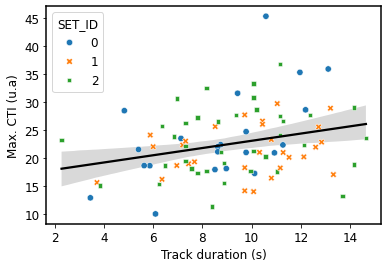

Replicate   0 --  R_value : 0.56 	p_value : 0.01  Ntracks: 22
Replicate   1 --  R_value : 0.25 	p_value : 0.19  Ntracks: 29
Replicate   2 --  R_value : 0.16 	p_value : 0.33  Ntracks: 38


In [73]:
from sklearn import datasets, linear_model

### Using Raw Imax
data_aux = data_CH1.query(" Protein in ['Sec2','Sec18','Sec9'] and Dur<16 and Dur>0").copy()
fit = stats.linregress(data_aux["Dur"],data_aux["Imax_C1"])
print("Replicate All -- ","R_value : %.2f" %fit.rvalue, "\tp_value : %.2f"%fit.pvalue," Ntracks: %d"%len(data_aux))

sns.regplot(data=data_aux,x="Dur",y="Imax_C1",scatter_kws={"s":0},color='k')
sns.scatterplot(data=data_aux,x="Dur",y="Imax_C1",hue="SET_ID",palette='tab10',style="SET_ID",s=40)

plt.xlabel("Track duration (s)")
plt.ylabel("Max. CTI (u.a)")
plt.savefig("Figures/Correlation_Dur_MaxI.png",dpi=200)
plt.show()

for ids in [0,1,2]:    
    fit = stats.linregress(data_aux.query("SET_ID==@ids")["Dur"],data_aux.query("SET_ID==@ids")["Imax_C1"])
    print("Replicate %3d -- "%ids,"R_value : %.2f" %fit.rvalue, "\tp_value : %.2f"%fit.pvalue,
          " Ntracks: %d"%len(data_aux.query("SET_ID==@ids")))


In [23]:
stats.pearsonr(data_aux["Dur"],data_aux["Imax_C1"])

(0.278118975283803, 0.008316071900693226)

## Fig_S11: Correlation between the release dynamics of exocyst and other protein clusters 
## Fig_5C: Sec18 is necessary for the exocyst to depart from exocytic sites


,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-0.0050,-1.2254,-0.0108,0.9517,0.0817,Sec2,0.0001
1,0.5351,-1.4625,0.4803,0.0013,0.1545,Sec9,0.2307
2,0.9407,0.4746,0.8412,0.0003,0.1823,Sec18,0.7076


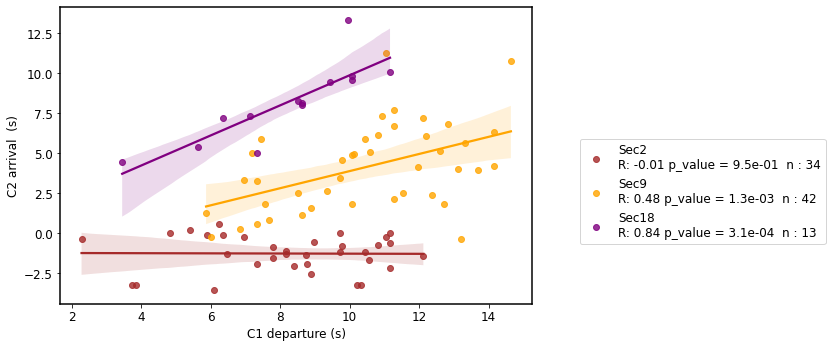

In [18]:
## Correlation between C2_arrival_time and C1_departure_time
#Fig_4C: Sec18 is necessary for the exocyst to depart from exocytic sites
fit = []
plt.figure(figsize=(12,5))
for i in ["Sec2","Sec9","Sec18"]:
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["To_CH2"]
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 arrival  (s)")
plt.xlabel("C1 departure (s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
#fit.to_csv("Correlation_fit_C2arrivaltime.csv")
fit

,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-0.2067,0.9028,-0.1834,0.2991,0.1958,Sec2,0.0336
1,-0.1089,3.6352,-0.2139,0.1738,0.0786,Sec9,0.0458
2,-0.0321,4.5812,-0.0597,0.8463,0.1618,Sec18,0.0036


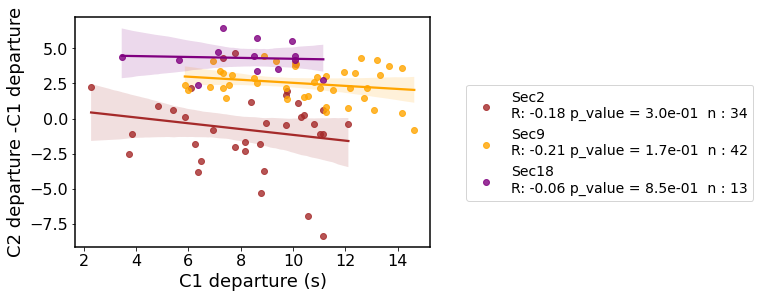

In [29]:
#Fig_S13A: Correlation between the C1 release and  C2 release times

fit = []
plt.figure(figsize=(12,5))

for i in ["Sec2","Sec9","Sec18"]:    
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["Tf_CH2"]-data["Dur"]
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 departure -C1 departure")
plt.xlabel("C1 departure (s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2departuretime_v2.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
#fit.to_csv("Correlation_fit_C2departuretime_v2.csv")
fit

,slope,intercept,rvalue,pvalue,stderr,Protein,R2
0,-1.0050,-1.2254,-0.9086,0.0000,0.0817,Sec2,0.8256
1,-0.4649,-1.4625,-0.4296,0.0045,0.1545,Sec9,0.1845
2,-0.0593,0.4746,-0.0976,0.7511,0.1823,Sec18,0.0095


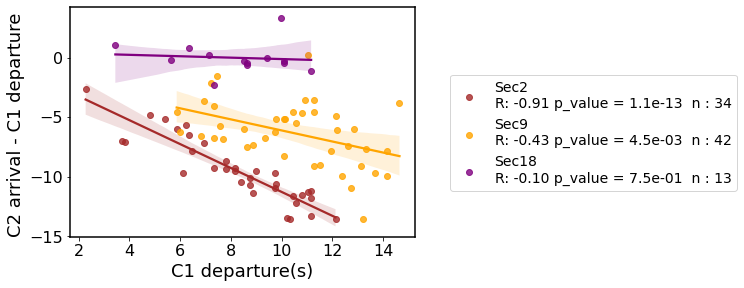

In [30]:
#Fig_S13A: Correlation between the C1 release and  C2 clustering times
fit = []
plt.figure(figsize=(12,5))
for i in ["Sec2","Sec9","Sec18"]:    
    data = data_CH1.query("""Protein==@i and Dur<15""").copy()
    x = data["Dur"]
    y = data["To_CH2"]-data["Dur"]        
    p = list(stats.linregress(x,y))+[i]
    fit.append(p)
    sns.regplot(data=data,x=x,y=y,
                label= "%s\nR: %4.2f p_value = %.1e  n : %d"%(i,p[2],p[3],len(data)),color=colors[i])
plt.legend(loc=[1.1,0.2])
plt.ylabel("C2 arrival - C1 departure ")
plt.xlabel("C1 departure(s)")
plt.tight_layout()
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime_C1arrival.svg",dpi=200)
plt.savefig("Figures/Paper_plots/Correlation_plot_C2arrivaltime_C1arrival.png",dpi=200)
fit = pd.DataFrame(fit,columns=["slope","intercept","rvalue","pvalue","stderr","Protein"])
fit["R2"] = fit["rvalue"]**2
fit.to_csv("Correlation_fit_C2arrivaltime_C1arrival.csv")
fit

## Fig3D: Average intensity profiles

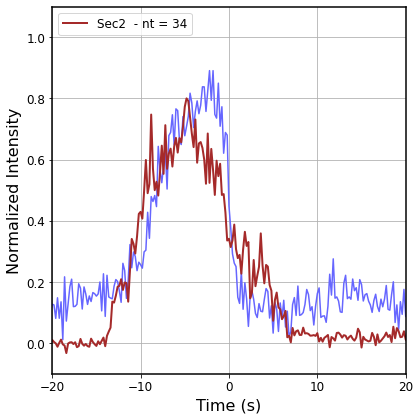

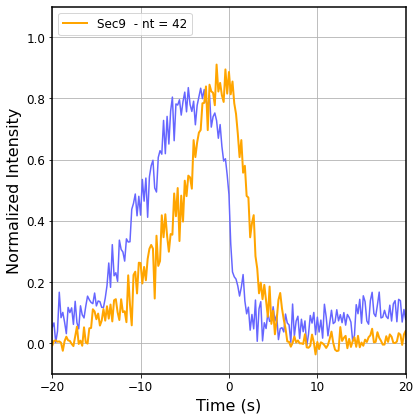

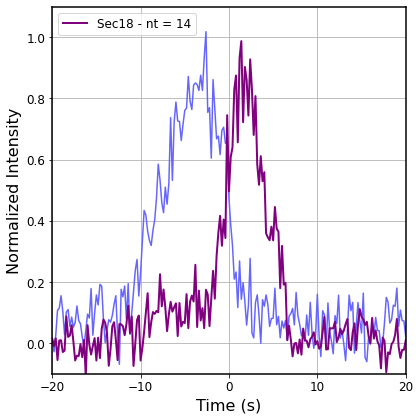

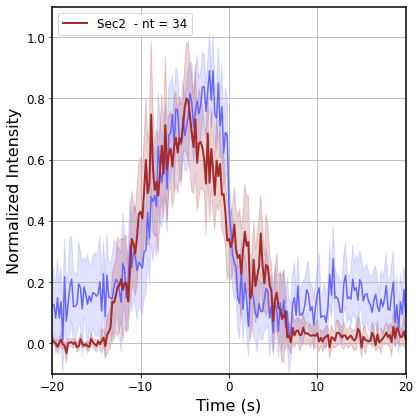

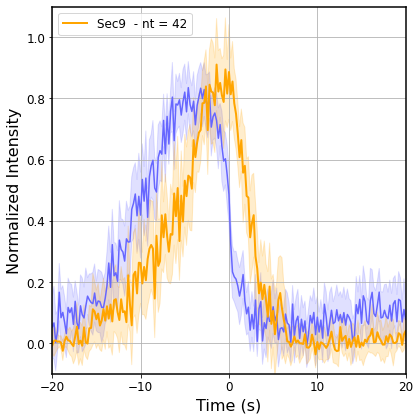

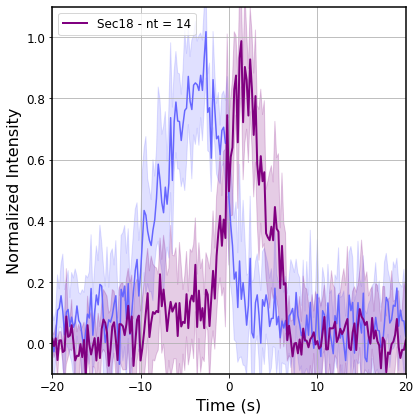

In [71]:
colors = {"Sec9_AA":"c","Sec2":"brown","Control":"b","Sec9":"orange","Sec18":"purple","Sec17":"y",
         "Exocyst":[102/255,102/255,255/255]}

np.savetxt("Final_Data_Timeline/allprots_exo84.dat",
          np.stack((ts,inten_exo84,std_exo84),axis=1))
exodur = 9.4

for j,s in enumerate(['',"CI"]):
    for idp in ["Sec2","Sec9","Sec18"]:
        plt.figure(figsize=(6,6))
        
        data_aux= data_CH1.query("Protein=='%s'"%idp).copy()
        exodur  = data_CH1["Dur"].median()
        
        data  = intenC1[idp].copy()
        sd    = data[1].copy()
        y     = data[0].copy()
        #y  = savgol_filter(y,10,1) #/np.max(y[0])    
        #sd = savgol_filter(std_exo84,10,1) #/np.max(y[0])    
        sd    =  sd/np.sqrt(data[2])*1.95
        #y /= np.max(y)       
        plt.plot(ts,y,color=colors["Exocyst"])
        
        if s == "CI": 
            plt.fill_between(ts,y-sd,y+sd,color=colors["Exocyst"],alpha=0.2)     
            
        data  = intenC2[idp].copy()
        sd    = data[1].copy()
        y     = data[0].copy()
        #sd   /= np.max(y)
        #y    /= np.max(y)
        
        if s  != "CI":
            np.savetxt("Final_Data_Timeline/%s_%dtracks.dat"%(idp,data[2]),
                       np.stack((ts,y,sd),axis=1))
            
        #y     = savgol_filter(y,10,1) #/np.max(y[0])    
        #y     /= np.max(y)
        plt.plot(ts,y,label=idp.ljust(6) + r"- nt = %d"%data[2],color=colors[idp],lw=2)    
        sd    =  sd/np.sqrt(data[2])*1.95
        #sd    =  savgol_filter(sd,10,1)
        if s == "CI":
            plt.fill_between(ts,y-sd,y+sd,alpha=0.2,color=colors[idp]) 
       
        data_aux= data_CH1.query("Protein=='%s'"%idp).copy()
        
        to     = data_aux["To_CH2"].mean() - exodur  
        to_std = data_aux["To_CH2"].std()  - exodur
        
        tf     = data_aux["Tf_CH2"].mean() -exodur
        tf_std = data_aux["Tf_CH2"].std()  -exodur
        
        plt.legend(loc='upper left',fontsize=12)
        plt.ylabel("Normalized Intensity",fontsize=16)        
        plt.xlabel("Time (s)",fontsize=16)    
        plt.xticks(np.arange(-20,21,10))
        plt.yticks(np.arange(0,1.1,0.2))    
        plt.xlim(-20,20)
        plt.ylim(-0.1,1.1)        
        plt.grid()    
        
        plt.tight_layout()
        plt.savefig("Figures/Paper_plots/Timeline_%s_%s.png"%(s,idp),dpi=200,facecolor='w')        
    